# Welcome to IonNet!

This notebook contains a worked example of how to train a model for nanochannel water density estimation.

The cell below imports all of the relevant packages and functions we will need.

In [1]:
from model import *
from utils import binMolDen
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from random import sample
from sklearn import metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.utils.data import dataset, DataLoader

## Creating datasets for model training

Pytorch contains many useful modules for handling data. The modules here will handle batching and shuffling to make training easier.

In [2]:
# Load training data
data = np.load('data/train.npz')['data']

# Split data into training and validation splits to aid in model selection
train_data, valid_data= split_data(
        data, valid_ratio = 0.00,
        randomSeed = 2022
)

# Load test data
test_data = np.load('data/test.npz')['data']

# Create our custom Ion Datasets. This class handles returning data as features and targets
train_dataset = IonDataset(data = train_data)
valid_dataset = IonDataset(data = valid_data)
test_dataset = IonDataset(data = test_data)

The random seed is:  2022
Train size: 2400000, Validation size: 0


In [3]:
# DataLoaders allow us to iterate over the dataset where shuffling and batching is handled for us
train_loader = DataLoader(
    train_dataset,      # Our custom dataset object that will return features and targets
    batch_size=1024,    # Batch size is the number of samples we average over for each gradient step
    num_workers=0,      # Workers can load data in parallel, which can be useful for large data sets
    drop_last=False,    # The last batch may not be the full batch_size, but we can still use it for training
    shuffle=True        # Shuffle the data to satisfy IID assumption of gradient based optimizers
)

valid_loader = DataLoader(
    valid_dataset, batch_size=1024, num_workers=0, drop_last=False, 
    shuffle=False
)

test_loader = DataLoader(
    test_dataset, batch_size=1024, num_workers=0, drop_last=False, 
    shuffle=False
)
print('Train size =\t\t', len(train_data))
print('Validation size =\t', len(valid_data))
print('Test size =\t\t', len(test_data))

Train size =		 2400000
Validation size =	 2400000
Test size =		 1050000


## Set up our model and optimizer for training

In this cell we initialize our model and set up the optimizer for training. Optimizer hyperparameters can greatly influence training results and must be chosen carefully.

In [4]:
# Set our device to use the cuda-based GPU if it is available
device = 'cuda' if(torch.cuda.is_available()) else 'cpu'

# Loss function
criterion = nn.MSELoss()

# Initialize our model
model = IonNet(n_in=6, activation='ReLU').to(device)

# Use the popular Adam optimizer with our model
optimizer = optim.Adam(
               model.parameters(),  # Pass in our model parameters that we are training
               lr=0.005,            # Learning rate controls how large the step size is
               weight_decay=0       # Weight decay helps minimize overfitting
)

# Learning rate schedulers often help with training
scheduler = StepLR(
              optimizer,       # Pass in our optimizer that we will modify as training progresses
              step_size=1000,  # Modify learning rate after every step_size training steps
              gamma=0.1        # Multiply our learning rate by gamma after every step_size training steps
)

# This folder is where we will store our model during training
model_checkpoints_folder = os.path.join('train/', 'NN')

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.




## Training setup

In this cell we set our number of epochs, how often we would like to log our results, and the metrics we will use for model selection.

In [5]:
# How many complete passes over the data we will do during training
#n_epochs=100
n_epochs=1

# How often we would like to print out training progress. This prints after every log_every batches
log_every = 500

# How often we would like to calculate validation loss for our model
val_every = 1  # Validate model after every epoch

# Initialize best values to be worst case possible
best_valid_loss = np.inf  # We are looking for minimum validation loss
best_valid_mae = np.inf   # We are looking for minimum validation MAE
best_valid_roc_auc = 0    # We are looking for maximum validation ROC

## Training loop

Now we are ready to train our model. We take optimizer steps on our training set, but not our validation set. Performance on the validation set allows us to select the model parameters that perform best for testing.

In [6]:
# Run training for n_epochs total passes over the data
for epoch_counter in range(n_epochs):
    
    # Set our model to training mode when learning from training data
    model.train()
    for bn, (inputs, target) in enumerate(train_loader):

        # Put our training features and targets on either CPU or GPU
        input_var = inputs.to(device)
        target = target.to(device)
        
        # Do forward pass through our model to compute its prediction
        output = model(input_var)

        # Calculate loss from current prediction
        loss = criterion(output, target)


        # Always zero gradients before calculating them from the next batch
        optimizer.zero_grad()
        
        # Do backpropagation pass to compute gradients from current batch
        loss.backward()
        
        # Use our optimizer to take a gradient step on our model parameters
        optimizer.step()
        
        # Print out our training progress every log_every steps
        if bn % log_every == 0:
            print('Epoch: %d, Batch: %d, Loss:'%(epoch_counter+1, bn), loss.item())
            
    # Take a step on our optimizer scheduler. Reduces learning rate every step_size steps
    scheduler.step()

    # validate the model if requested
    if epoch_counter % val_every == 0:
        
        # Initialize loss average objects to track loss over entire validation set
        losses = AverageMeter()
        mae_errors = AverageMeter()
        
        # Use no_grad context to increase computational efficiency and ensure 
        # we are not training on validation data
        with torch.no_grad():
            
            # Switch model to evaluation mode so that parameters are not updated on validation data
            model.eval()
            
            # Do pass over validation set
            for bn, (inputs, target) in enumerate(valid_loader):
                
                # Put our validation features and targets on either CPU or GPU
                input_var = inputs.to(device)
                target = target.to(device)
                
                # Do forward pass through our model to compute its prediction
                output = model(input_var)
                
                # Calculate loss. Note that no backward pass is done here because we are validating our model
                loss = criterion(output, target)
                
                # Calculate MAE error and add it to average meter
                mae_error = mae(output, target)
                mae_errors.update(mae_error, target.size(0))

            # Print the validation results
            print('Epoch [{0}] Validate: [{1}/{2}], '
                    'MAE {mae_errors.val:.3f} ({mae_errors.avg:.3f})'.format(
                epoch_counter+1, bn+1, len(valid_loader),
                mae_errors=mae_errors))

        # Save our model parameters if our validation MAE is a new minimum
        if mae_errors.avg < best_valid_mae:
            best_valid_mae = mae_errors.avg
            
            # Save our model's state dictionary to the path defined earlier
            torch.save(model.state_dict(), os.path.join(model_checkpoints_folder, 'model.pth'))


Epoch: 1, Batch: 0, Loss: 0.17428240180015564
Epoch: 1, Batch: 500, Loss: 0.0066730305552482605
Epoch: 1, Batch: 1000, Loss: 0.0046768877655267715
Epoch: 1, Batch: 1500, Loss: 0.0016665300354361534
Epoch: 1, Batch: 2000, Loss: 0.001216829288750887
Epoch [1] Validate: [2344/2344], MAE 0.015 (0.015)


## Testing our model

This is where we evaluate model performance on data it has not seen yet.

In [7]:
# Load our best model (lowest validation MAE) from the training loop
state_dict = torch.load(os.path.join(model_checkpoints_folder, 'model.pth'), map_location=device)
model.load_state_dict(state_dict)

##
# Do the same forward pass as in validation for our test data
##

# Initialize loss average objects to track loss over entire test set
mae_errors = AverageMeter()

# Use no_grad context to increase computational efficiency and ensure 
# we are not training on test data
with torch.no_grad():

    # Switch model to evaluation mode so that parameters are not updated on test data
    model.eval()
    
    # Do pass over validation set
    for bn, (inputs, target) in enumerate(test_loader):
        
        # Put our test features and targets on either CPU or GPU
        input_var = inputs.to(device)
        target = target.to(device)
        
        # Calculate loss. Note that no backward pass is done here because we are testing our model
        output = model(input_var)
        
        # Calculate MAE error and add it to average meter
        mae_error = mae(output.data, target)
        mae_errors.update(mae_error, target.size(0))

    # Print the test results
    print('Epoch [{0}] Test: [{1}/{2}], '
            'MAE: {mae_errors.avg:.3f}'.format(
        epoch_counter+1, bn+1, len(test_loader),
        mae_errors=mae_errors))


Epoch [1] Test: [1026/1026], MAE: 0.016


## Vizualizing results

Now that we have evaluated our trained model, we vizualize the results.

In [8]:
# Set the size of the nano channel used for training
gap=2.0

# Set the size of the bins used for CDF/PDF calculation
binSize=0.02
bins = np.array([i*binSize for i in range(int((gap/2+0.1)//binSize))])

# Like in validation and testing, use the no_grad context to speed up computational efficiency and
# ensure we are not training on our new data
with torch.no_grad():
    
    # Switch model to evaluation mode so that parameters are not updated on test data
    model.eval()
    
    # Calculate the CDF value for each bin
    cdf = []
    for b in bins:
        
        # Create a torch tensor of our evaluation data and put it on CPU or GPU
        p = model(torch.tensor([b, gap, 2.2, 4.8305, 0.0128, -1]).float().to(device))
        
        # Make sure our prediction is back on the CPU and a data type that can be plotted easily
        p = p.cpu().numpy()
        
        # Hold on to prediction
        cdf.append(p)
        
    # Make PDF calculation easier then calculate is
    cdf = np.array(cdf)
    pdf = cdf[1:]-cdf[:-1]

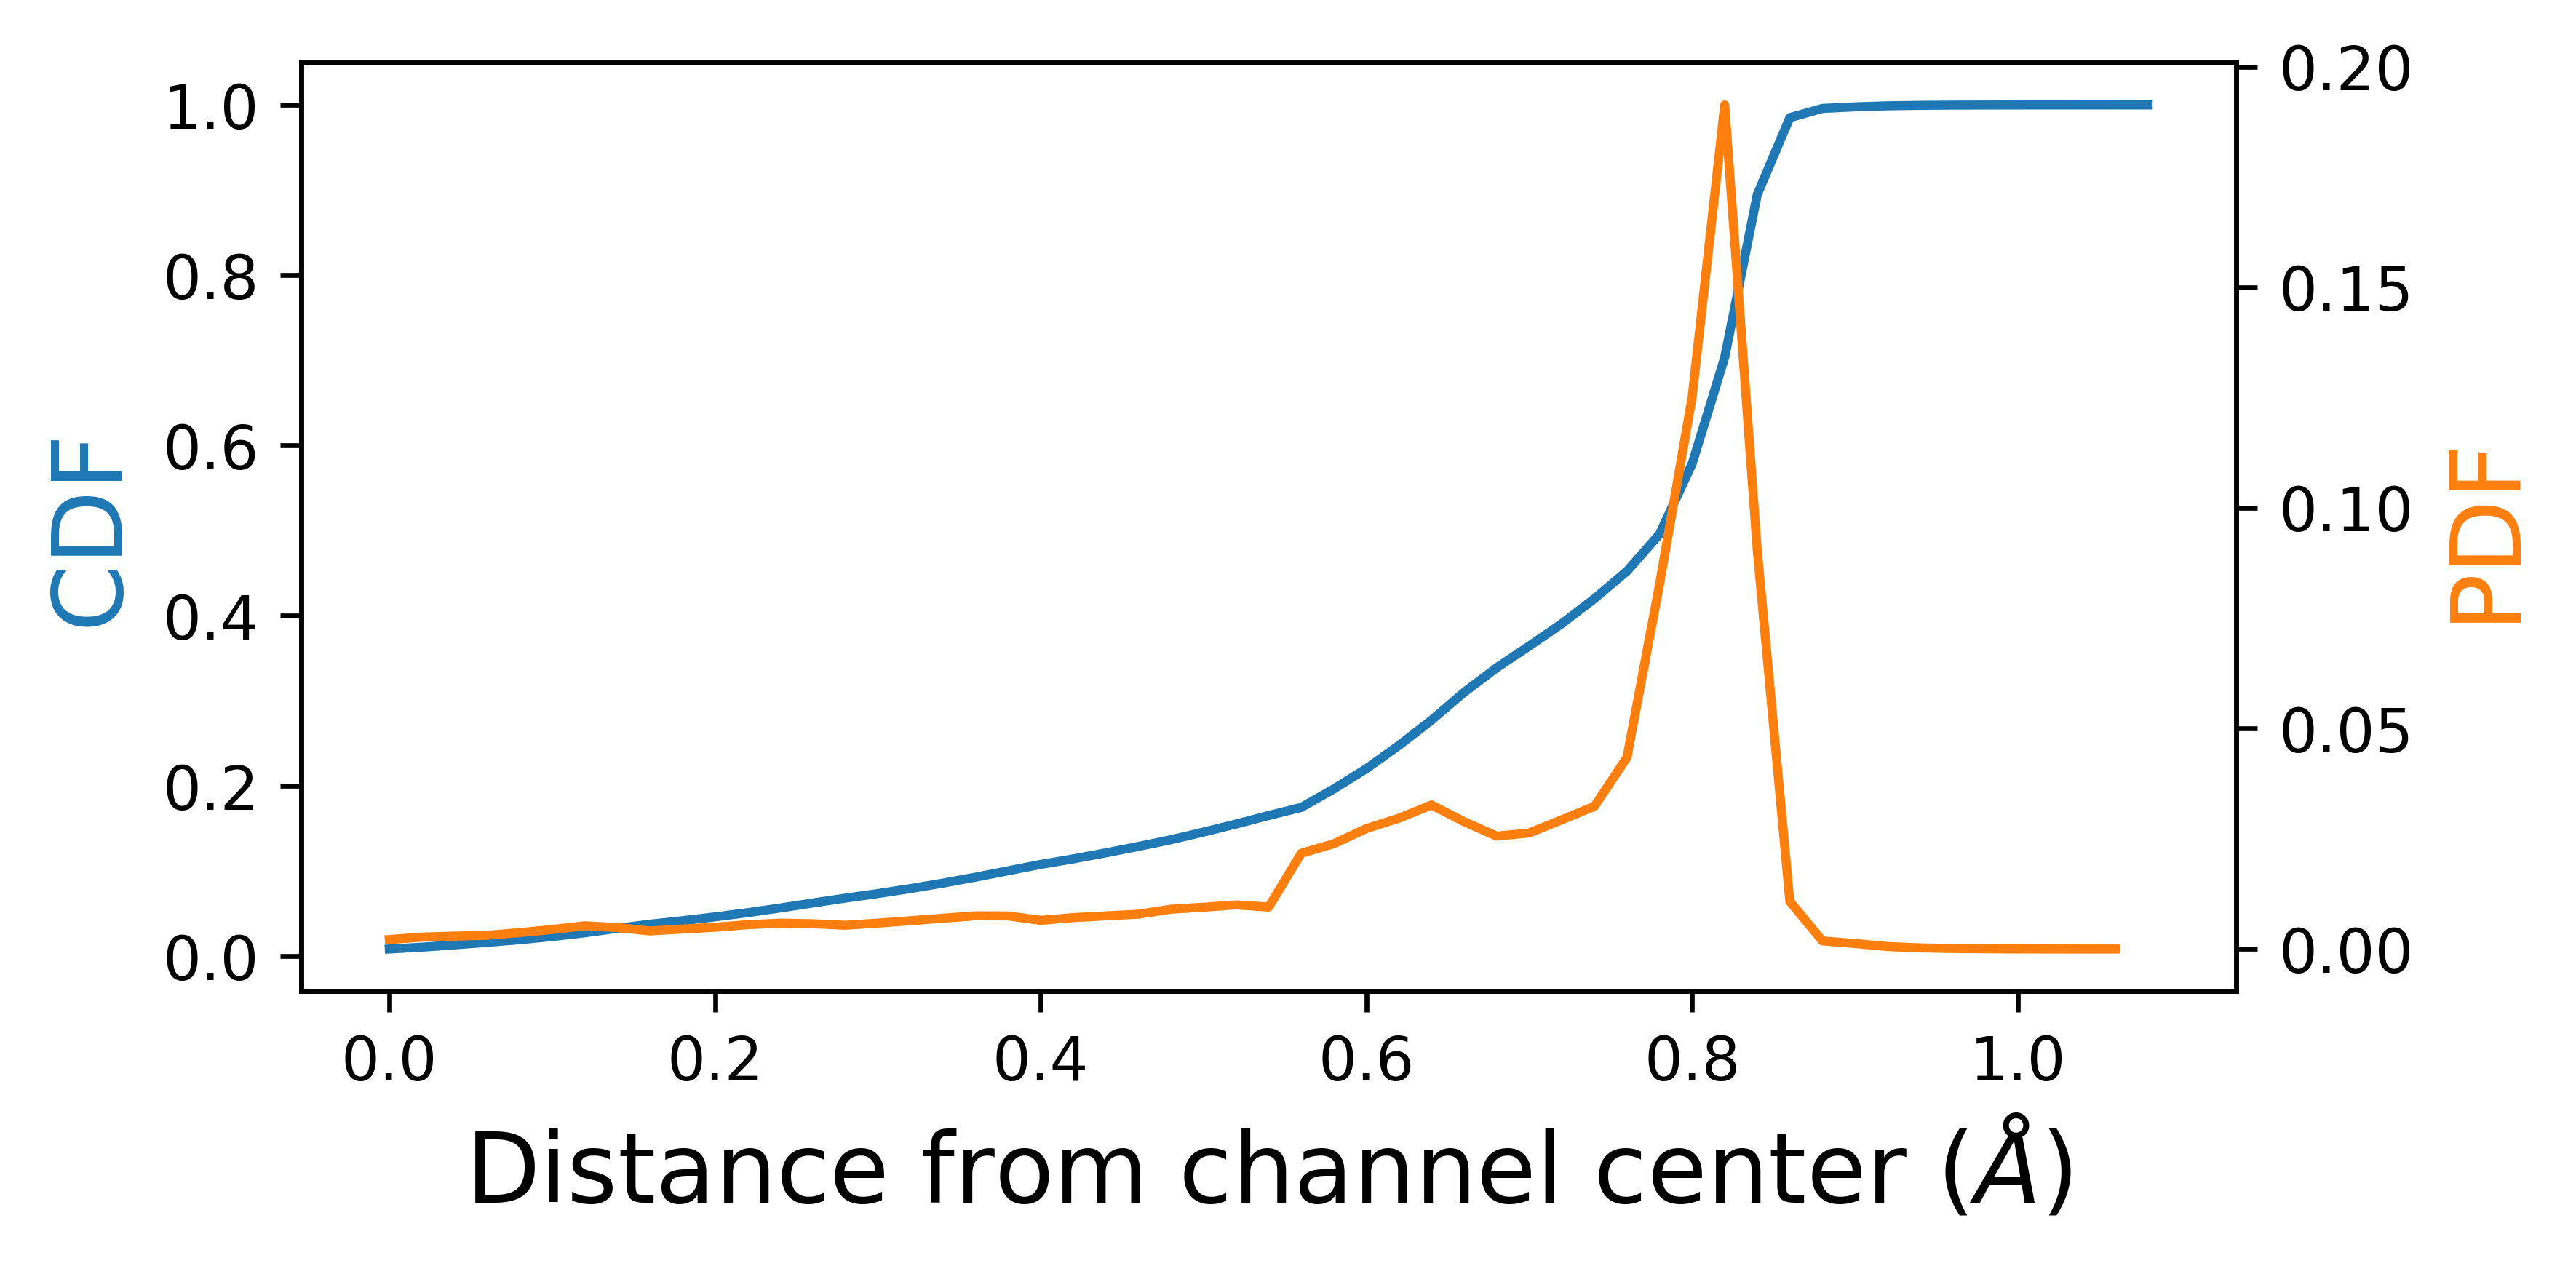

In [9]:
# Plot PDF and CDF with matplotlib
fig, ax = plt.subplots(figsize = (6, 3), dpi=600)
ax2 = ax.twinx()

# Plot our model's predicted CDF and PDF
ax.plot(bins, cdf, color = 'C0')
ax2.plot(bins[:-1], pdf, color = 'C1')
 
# giving labels to the axises
ax.set_xlabel('Distance from channel center ($\AA$)', fontsize=16)
ax.set_ylabel('CDF', color = 'C0', fontsize=16)
ax2.set_ylabel('PDF', color = 'C1', fontsize=16)
 
# defining display layout
plt.tight_layout()